# A Temperature-Forecasting Problem

In this notebook, we are going to cover:

* How to deal with sequential data
* Recurrent Neural Networks (RNNs)

<div style="display: inline-block"><img src="images/RNN.png" width=480 height=360></div>

Since we are working on sequential data-sets, we need to predict targets based on previous words or data. Recurrent Neural networks helps us to carry early informations for further predictions. Thus, we can preserve sequential order and make more accurate predictions.

* Gated Recurrent Units (GRUs)

<div style="display: inline-block"><img src="images/GRU.png" width=480 height=360></div>

However, RNN isn't very well to capture long-range dependencies. This problem leads to `vanishing gradient problem` that means lead to NaN which is computationally overflowed. GRU is developed to solve this issue. In GRU, `tanh`, and `sigmoid` activation functions are applied to information from previous activation and current input.

<img src="images/GRUFormula.png">


Dataset is collected by Jena Climate from 2009 to 2016 for each 10 min

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip

--2020-10-11 15:00:57--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.25.142
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.25.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13568290 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  14.3MB/s    in 0.9s    

2020-10-11 15:00:58 (14.3 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13568290/13568290]



In [3]:
!unzip jena_climate_2009_2016.csv.zip

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  


In this dataset, we have many parameters like temperature, air pressure, humidity, and 11 more.

In [4]:
df = pd.read_csv('jena_climate_2009_2016.csv')
df

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.20,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.10,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420546,31.12.2016 23:20:00,1000.07,-4.05,269.10,-8.13,73.10,4.52,3.30,1.22,2.06,3.30,1292.98,0.67,1.52,240.0
420547,31.12.2016 23:30:00,999.93,-3.35,269.81,-8.06,69.71,4.77,3.32,1.44,2.07,3.32,1289.44,1.14,1.92,234.3
420548,31.12.2016 23:40:00,999.82,-3.16,270.01,-8.21,67.91,4.84,3.28,1.55,2.05,3.28,1288.39,1.08,2.00,215.2
420549,31.12.2016 23:50:00,999.81,-4.23,268.94,-8.53,71.80,4.46,3.20,1.26,1.99,3.20,1293.56,1.49,2.16,225.8


### Plotting the Temperature (in degree Celsius) For Each Time Steps

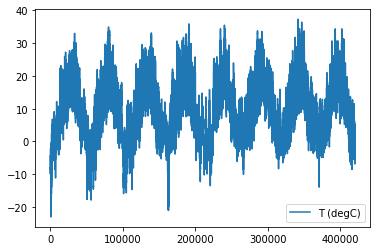

In [ ]:
df[['T (degC)']].plot()

* Temperature over the first 10 days of the dataset in degrees Celcius.
* Since the 10 day period coming from winter, temperatures are mostly below 0 degrees Celcius.

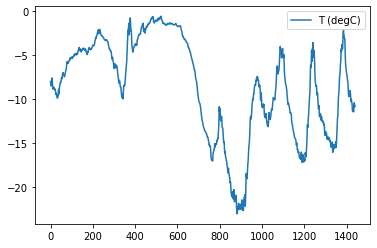

In [ ]:
df[['T (degC)']].iloc[:1440].plot()

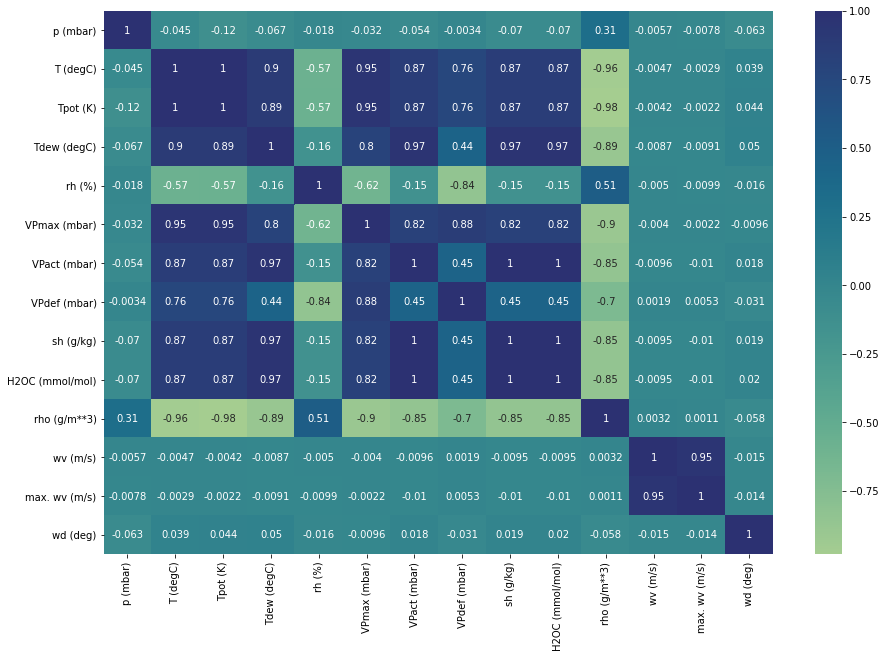

In [10]:
fig = plt.figure(figsize=(15,10))
sns.heatmap(df.corr(), annot=True, cmap="crest")
plt.show()

Heatmap stands for the correlation of features in the dataset as visual. As we can see there are many relational attributes in this weather dataset. We can count p(mbar), wv(m/s), max. wv(m/s), and wd(deg) features as useless since they are not correlated with any one of the other attributes even with output. But now, let's continue with this setting.

### Normalizing Dataset

In [ ]:
float_data = df.iloc[:, 1:].values
mean = np.mean(float_data[:200000, :], axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In this example, we will be using each hour as samples instead of every 10 min. Besides, we are going to look back to predict the future. For this reason, the `generator` function has been constructed to take all required parameters, and build the train, validation, and test generators. As a basic explanation of that, each lookback creates a group of hours, (in this case it is 240) and the corresponding parameters for each hour. That constructs the `sample` matrix in the shape of a 3D tensor (samples, hours, parameters). To build a generator, we are using the `yield` statement instead of `return`.

In [ ]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(row - lookback, row, step)
            samples[j] = data[indices]
            targets[j] = data[row + delay][1]
        yield samples, targets

* `lookback` = How many timesteps back the model should look.
* `step` = Steps in the period, 6 means there will be an hour between each time step.
* `delay` = Determines how far away the weather condition will be set as a target. 

In [ ]:
lookback = 1440 # In this case, it looks 10 days before.
step = 6 # Takes each hour into a count instead of every 10 min.
delay = 144 # Determines target as 24 hours later.
batch_size = 128

In [ ]:
rows = np.random.randint(0 + lookback, 200000, size=batch_size)
indices = range(rows[0] - lookback, rows[0], step)
indices

range(64589, 66029, 6)

200000 samples are split for training, whereas the next 100000 are split for validation and remaining for test data.

In [ ]:
train_gen = generator(float_data, lookback=lookback, delay=delay, min_index = 0, max_index=200000, shuffle=True, step=step, batch_size=batch_size)
val_gen = generator(float_data, lookback=lookback, delay=delay, min_index=200001, max_index=300000, step=step, batch_size=batch_size)
test_gen = generator(float_data, lookback=lookback, delay=delay, min_index=300001, max_index=None, step=step, batch_size=batch_size)

# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (300000 - 200001 - lookback) // batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(float_data) - 300001 - lookback) // batch_size

The reason why we shuffled training indices is the temperature of tomorrow is most likely close to the temperature of today and you can think that it would be easy to estimate temperatures tomorrow. In order to observe the truthness of this assumption let's take the validation data in the manual process. For the sake of argument, the temperature of each sample's last hour has been taken as prediction and evaluated using the Mean Absolute Error (MAE) metric.

In [ ]:
def evaluate_naive_method():
  batch_maes = []
  for step in range(val_steps):
    samples, targets = next(val_gen)
    preds = samples[:, -1, 1]
    mae = np.mean(np.abs(preds - targets))
    batch_maes.append(mae)
  print(np.mean(batch_maes))

evaluate_naive_method()

0.28973597299054815


Since we have normalized data, we should multiply it with the standard deviation to get the exact average `MAE`.

In [ ]:
celsius_mae = 0.29 * std[1]
celsius_mae

2.567224733839344

### Evaluating Data With Dense Layers

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 11s 22ms/step - loss: 1.4894 - val_loss: 0.8660
Epoch 2/20
500/500 [==============================] - 11s 22ms/step - loss: 0.4683 - val_loss: 0.3041
Epoch 3/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2953 - val_loss: 0.3054
Epoch 4/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2714 - val_loss: 0.3144
Epoch 5/20
500/500 [==============================] - 11s 21ms/step - loss: 0.2570 - val_loss: 0.3083
Epoch 6/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2477 - val_loss: 0.3079
Epoch 7/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2383 - val_loss: 0.3301
Epoch 8/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2325 - val_loss: 0.3231
Epoch 9/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2290 - val_loss: 0.3288
Epoch 10/20
500/500 [==============================] - 11s 22ms/step - loss: 0.224

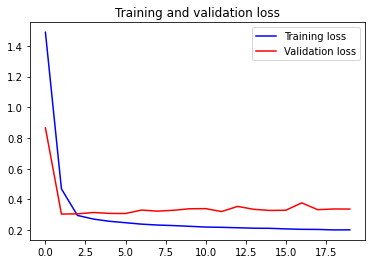

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Since losses were pretty high at the beginning of training, it is hard to visualize the gap between training and validation loss. Let's plot the results after 1st epoch and look more closely.

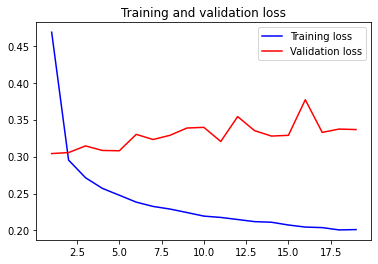

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs[1:], loss[1:], 'b', label='Training loss')
plt.plot(epochs[1:], val_loss[1:], 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Now, we can observe the result better. After 2$^{nd}$ epoch, the model tends to overfit since training loss decreasing gradually towards 0.20 while validation loss oscillating between 0.30 and 0.40 MAE.

### Evaluation With Gated Recurrent Units (GRU)

* Let's evaluate the dataset with GRU, which helps us to keep the sequence in memory.

In [ ]:
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit(train_gen,
                    steps_per_epoch=500,
                    epochs=20,
                    validation_data=val_gen,
                    validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 15s 31ms/step - loss: 0.2995 - val_loss: 0.2766
Epoch 2/20
500/500 [==============================] - 15s 31ms/step - loss: 0.2857 - val_loss: 0.2656
Epoch 3/20
500/500 [==============================] - 15s 30ms/step - loss: 0.2794 - val_loss: 0.2627
Epoch 4/20
500/500 [==============================] - 15s 30ms/step - loss: 0.2732 - val_loss: 0.2679
Epoch 5/20
500/500 [==============================] - 14s 29ms/step - loss: 0.2686 - val_loss: 0.2635
Epoch 6/20
500/500 [==============================] - 14s 29ms/step - loss: 0.2654 - val_loss: 0.2629
Epoch 7/20
500/500 [==============================] - 15s 29ms/step - loss: 0.2613 - val_loss: 0.2669
Epoch 8/20
500/500 [==============================] - 14s 29ms/step - loss: 0.2561 - val_loss: 0.2697
Epoch 9/20
500/500 [==============================] - 14s 29ms/step - loss: 0.2507 - val_loss: 0.2686
Epoch 10/20
500/500 [==============================] - 15s 29ms/step - loss: 0.247

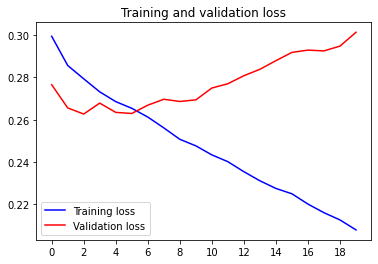

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.xticks(range(0,22,2))
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### GRU With Regularization

It has long been known that applying regular dropout in RNN models is wrecking training performance determined by Yarin Gal, in 2015 as part of his Ph.D. thesis. "See Yarin Gal, "Uncertainty in Deep Learning (PhD Thesis)" October 13, 2016, http:mlg.eng.cam.ac.uk/yarin/blog_2248.html"

Instead, we should apply recurrent dropout to the inner recurrent activation. However, we are losing the power of cuDNN when we use recurrent dropout since it has not been supported by Keras in a low level yet. 

For this reason, we will use recurrent_regularizer. That will help us to prevent overfitting without losing performance.

In [ ]:
from keras.regularizers import L2

l2_regularizer = L2(l2=0.01)

model = Sequential()
model.add(layers.GRU(32, recurrent_regularizer=l2_regularizer, input_shape=(None, float_data.shape[-1])))
model.add(layers.BatchNormalization())
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit(train_gen,
                    steps_per_epoch=500,
                    epochs=20,
                    validation_data=val_gen,
                    validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 15s 31ms/step - loss: 0.4048 - val_loss: 0.3004
Epoch 2/20
500/500 [==============================] - 16s 32ms/step - loss: 0.3201 - val_loss: 0.2986
Epoch 3/20
500/500 [==============================] - 16s 31ms/step - loss: 0.3097 - val_loss: 0.2772
Epoch 4/20
500/500 [==============================] - 16s 31ms/step - loss: 0.3008 - val_loss: 0.2731
Epoch 5/20
500/500 [==============================] - 16s 31ms/step - loss: 0.2986 - val_loss: 0.2759
Epoch 6/20
500/500 [==============================] - 16s 31ms/step - loss: 0.2947 - val_loss: 0.2703
Epoch 7/20
500/500 [==============================] - 16s 31ms/step - loss: 0.2934 - val_loss: 0.2892
Epoch 8/20
500/500 [==============================] - 16s 32ms/step - loss: 0.2916 - val_loss: 0.2651
Epoch 9/20
500/500 [==============================] - 16s 32ms/step - loss: 0.2895 - val_loss: 0.2810
Epoch 10/20
500/500 [==============================] - 16s 33ms/step - loss: 0.288

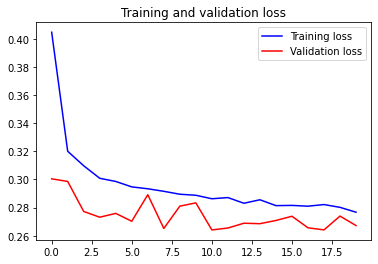

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

As shown above, validation loss is more stable now.

### Double Gru

For more computational power we can use our RNN models multiple time if needed. In this case, since our model does not overfit, we can safely add more layers.

In [ ]:
model = Sequential()
model.add(layers.GRU(32,
                     recurrent_regularizer=l2_regularizer,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64,
                     recurrent_regularizer=l2_regularizer))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 23s 46ms/step - loss: 0.4094 - val_loss: 0.2850
Epoch 2/20
500/500 [==============================] - 23s 46ms/step - loss: 0.3005 - val_loss: 0.2771
Epoch 3/20
500/500 [==============================] - 23s 45ms/step - loss: 0.2925 - val_loss: 0.2760
Epoch 4/20
500/500 [==============================] - 23s 46ms/step - loss: 0.2893 - val_loss: 0.2797
Epoch 5/20
500/500 [==============================] - 23s 47ms/step - loss: 0.2846 - val_loss: 0.2695
Epoch 6/20
500/500 [==============================] - 23s 46ms/step - loss: 0.2821 - val_loss: 0.2640
Epoch 7/20
500/500 [==============================] - 23s 46ms/step - loss: 0.2805 - val_loss: 0.2679
Epoch 8/20
500/500 [==============================] - 23s 45ms/step - loss: 0.2770 - val_loss: 0.2663
Epoch 9/20
500/500 [==============================] - 22s 45ms/step - loss: 0.2741 - val_loss: 0.2660
Epoch 10/20
500/500 [==============================] - 23s 45ms/step - loss: 0.269

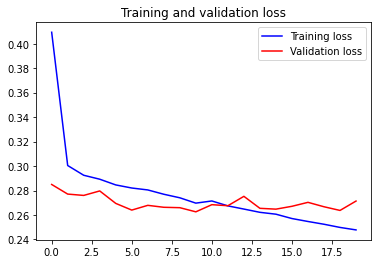

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

As a final thought, allowing a bit over-fitting in the model generally gives better results in the test data. Moreover, we don't want a model to bias towards the validation-set.